# Keras & MobileNet

In [279]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [280]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Fine-tune MobileNet

### Image preparation

In [281]:
# Organize data into train, valid, test dirs
'''
os.chdir('data/minimiasdivididoProcessedNOHISTEQ_DFV')
print(os.getcwd())
if os.path.isdir('train/Abnormal_ProcessNOHISTEQ') is False:
    os.makedirs('train/Normal_ProcessNOHISTEQ')
    os.makedirs('train/Abnormal_ProcessNOHISTEQ')
    os.makedirs('valid/Normal_ProcessNOHISTEQ')
    os.makedirs('valid/Abnormal_ProcessNOHISTEQ')
    os.makedirs('test/Normal_ProcessNOHISTEQ')
    os.makedirs('test/Abnormal_ProcessNOHISTEQ')
  
    for c in random.sample(glob.glob('./Abnormal_ProcessNOHISTEQ/*.png'), 90):  
        shutil.move(c, 'train/Abnormal_ProcessNOHISTEQ')      
    for c in random.sample(glob.glob('./Normal_ProcessNOHISTEQ/*.png'), 90):
        shutil.move(c, 'train/Normal_ProcessNOHISTEQ')
    for c in random.sample(glob.glob('./Abnormal_ProcessNOHISTEQ/*.png'), 13):
        shutil.move(c, 'valid/Abnormal_ProcessNOHISTEQ')        
    for c in random.sample(glob.glob('./Normal_ProcessNOHISTEQ/*.png'), 13):
        shutil.move(c, 'valid/Normal_ProcessNOHISTEQ')
    for c in random.sample(glob.glob('./Abnormal_ProcessNOHISTEQ/*.png'), 10):
        shutil.move(c, 'test/Abnormal_ProcessNOHISTEQ')      
    for c in random.sample(glob.glob('./Normal_ProcessNOHISTEQ/*.png'), 10):
        shutil.move(c, 'test/Normal_ProcessNOHISTEQ')

os.chdir('../../')
'''

"\nos.chdir('data/minimiasdivididoProcessedNOHISTEQ_DFV')\nprint(os.getcwd())\nif os.path.isdir('train/Abnormal_ProcessNOHISTEQ') is False:\n    os.makedirs('train/Normal_ProcessNOHISTEQ')\n    os.makedirs('train/Abnormal_ProcessNOHISTEQ')\n    os.makedirs('valid/Normal_ProcessNOHISTEQ')\n    os.makedirs('valid/Abnormal_ProcessNOHISTEQ')\n    os.makedirs('test/Normal_ProcessNOHISTEQ')\n    os.makedirs('test/Abnormal_ProcessNOHISTEQ')\n  \n    for c in random.sample(glob.glob('./Abnormal_ProcessNOHISTEQ/*.png'), 90):  \n        shutil.move(c, 'train/Abnormal_ProcessNOHISTEQ')      \n    for c in random.sample(glob.glob('./Normal_ProcessNOHISTEQ/*.png'), 90):\n        shutil.move(c, 'train/Normal_ProcessNOHISTEQ')\n    for c in random.sample(glob.glob('./Abnormal_ProcessNOHISTEQ/*.png'), 13):\n        shutil.move(c, 'valid/Abnormal_ProcessNOHISTEQ')        \n    for c in random.sample(glob.glob('./Normal_ProcessNOHISTEQ/*.png'), 13):\n        shutil.move(c, 'valid/Normal_ProcessNOHISTEQ'

In [282]:
train_path = 'data/minimiasdivididoProcessedNOHISTEQ_DFV/train'
valid_path = 'data/minimiasdivididoProcessedNOHISTEQ_DFV/valid'
test_path = 'data/minimiasdivididoProcessedNOHISTEQ_DFV/test'

In [283]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 180 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [284]:
assert train_batches.n == 180
assert valid_batches.n == 26
assert test_batches.n == 20
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

### Modify Model

In [285]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [286]:
#mobile.summary()

In [287]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [288]:
params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

In [289]:
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [290]:
#model.summary()

In [291]:
params = count_params(model)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 3209026

In [292]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [293]:
#model.summary()

In [294]:
params = count_params(model)
assert params['non_trainable_params'] == 2178240
assert params['trainable_params'] == 1052674

### Train the model

In [295]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [296]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10
18/18 - 4s - loss: 0.7724 - accuracy: 0.5778 - val_loss: 0.9431 - val_accuracy: 0.5000
Epoch 2/10
18/18 - 1s - loss: 0.5122 - accuracy: 0.7833 - val_loss: 0.8423 - val_accuracy: 0.4231
Epoch 3/10
18/18 - 1s - loss: 0.4490 - accuracy: 0.8167 - val_loss: 0.7423 - val_accuracy: 0.4615
Epoch 4/10
18/18 - 1s - loss: 0.3465 - accuracy: 0.9111 - val_loss: 0.7915 - val_accuracy: 0.4231
Epoch 5/10
18/18 - 1s - loss: 0.3156 - accuracy: 0.9167 - val_loss: 0.8021 - val_accuracy: 0.4615
Epoch 6/10
18/18 - 1s - loss: 0.2530 - accuracy: 0.9833 - val_loss: 0.8065 - val_accuracy: 0.4615
Epoch 7/10
18/18 - 1s - loss: 0.2233 - accuracy: 0.9833 - val_loss: 0.8751 - val_accuracy: 0.4615
Epoch 8/10
18/18 - 1s - loss: 0.1913 - accuracy: 0.9944 - val_loss: 0.8422 - val_accuracy: 0.5000
Epoch 9/10
18/18 - 1s - loss: 0.1709 - accuracy: 0.9889 - val_loss: 0.9326 - val_accuracy: 0.4615
Epoch 10/10
18/18 - 2s - loss: 0.1505 - accuracy: 0.9889 - val_loss: 1.0880 - val_accuracy: 0.4615


In [297]:
assert model.history.history.get('accuracy')[-1] > 0.95

### Predict

In [298]:
test_labels = test_batches.classes

In [299]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [300]:
test_batches.class_indices

{'Abnormal_ProcessNOHISTEQ': 0, 'Normal_ProcessNOHISTEQ': 1}

In [301]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [302]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [303]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[1 9]
 [3 7]]


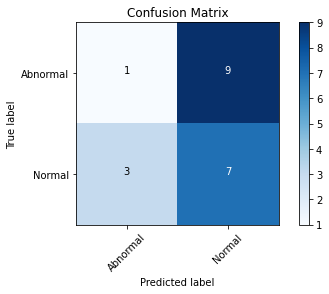

In [304]:
cm_plot_labels = ['Abnormal','Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [306]:
#assert np.sum(test_labels == predictions.argmax(axis=1)) > 8

# Data Augmentation

Data augmentation occurs when you create new data based on modifications of your existing data. In our case, our data will be images. Data augmentation on images would include transformations like:
 - Flipping the image either horizontally or vertically
 - Rotating the image
 - Zooming in or out on the image
 - Cropping the image
 - Varying the color on the image

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [35]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [36]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True)

In [37]:
chosen_image = random.choice(os.listdir('data/minimiasdivididoProcessedNOHISTEQ_DFV/train/Abnormal_ProcessNOHISTEQ'))

chosen_image

'mdb107_output.png'

In [38]:
image_path = 'data/minimiasdivididoProcessedNOHISTEQ_DFV/train/Abnormal_ProcessNOHISTEQ/' + chosen_image

image_path

'data/minimiasdivididoProcessedNOHISTEQ_DFV/train/Abnormal_ProcessNOHISTEQ/mdb107_output.png'

In [39]:
assert os.path.isfile(image_path)

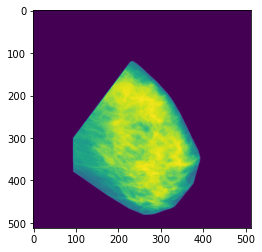

In [40]:
# Obtain image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [41]:
# Generate batches of augmented images from this image
aug_iter = gen.flow(image)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 512, 512))

In [315]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

NameError: name 'aug_iter' is not defined

In [316]:
# Augmented images
plotImages(aug_images)

NameError: name 'aug_images' is not defined